In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
from io import StringIO

old_stderr = sys.stderr
sys.stderr = StringIO()

### Preparing Oil Data

In [77]:
PETROL_FILE_PATH = '../../../volza/petroleum/petrol_crude_oil_spot_price.csv'

petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


### Preparing Export / Import Data

In [78]:
# COMBINED_FILE_PATH = '../../../volza/magnesium/magnesium_volza_ais_price.csv'
VOLZA_FILE_PATH = '../../../volza/copper/copper.csv'

# ****************** List of country codes available in the aligned data (at least for the China export ones) ******************
# COUNTRY_CODES = ['CN' 'BE' 'DE' 'NL' 'SE' 'TR' 'VN' 'MX' 'US' 'IL' 'CL' 'TW' 'ES' 'PL'
#  'RU' 'IN' 'FR' 'GB' 'BG' 'EE' 'IT' 'SI' 'FI' 'IE' 'DK' 'PT' 'LV' 'LT'
#  'HR' 'JP' 'BR' 'MA' 'GH' 'GR' 'RO' 'PA' 'EG' 'CY' 'HK']

EXPORT_COUNTRIES = ['Zambia', 'Namibia', 'Pakistan']
IMPORT_COUNTRIES = ['China', 'Namibia', 'Belgium', 'India', 'Germany', 'Tanzania','Netherlands', 'Zimbabwe']

try:
    combined_df = pd.read_csv(VOLZA_FILE_PATH)
except Exception as e:
    print(f"Error reading the CSV file: {e}")
finally:
    # Reset stderr
    sys.stderr.seek(0)
    warnings = sys.stderr.read()
    sys.stderr = old_stderr

# Count the number of bad lines
bad_lines_count = warnings.count('Skipping line')
print(f"Number of bad lines skipped: {bad_lines_count}")

if 'combined_df' in locals():
    combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='mixed')
    combined_df = combined_df.merge(brent_df[['Date', 'Brent Oil Value']], on='Date', how='left')
    combined_df = combined_df.merge(wti_df[['Date', 'WTI Oil Value']], on='Date', how='left')
    combined_df.sort_values('Date', inplace=True)
    combined_df.set_index('Date', inplace=True)



Number of bad lines skipped: 0


In [79]:
# ****************** Use this if using the aligned dataset ******************
# export_combined_df = combined_df[(combined_df['origin_country_code'].isin(EXPORT_COUNTRY_CODES))]
# import_combined_df = combined_df[(combined_df['destination_country_code'].isin(IMPORT_COUNTRY_CODES))]

export_combined_df = combined_df[(combined_df['Country of Origin'].isin(EXPORT_COUNTRIES))]
import_combined_df = combined_df[(combined_df['Country of Destination'].isin(IMPORT_COUNTRIES))]

# ****************** Just something to check the top importers of products from X country ******************
check_df = combined_df.groupby('Country of Destination')['Value'].sum()
top_importers = check_df.sort_values(ascending=False).head(50)
print(top_importers)

# ****************** Use this if using the aligned dataset ******************
# export_group = export_combined_df.groupby('origin_country')
# import_group = import_combined_df.groupby('destination_country')

export_group = export_combined_df.groupby('Country of Origin')
import_group = import_combined_df.groupby('Country of Destination')

Country of Destination
China                    2.714694e+10
Namibia                  1.536867e+10
Belgium                  1.098795e+10
India                    7.022841e+09
Germany                  5.077474e+09
Tanzania                 4.019148e+09
Netherlands              3.949570e+09
Zimbabwe                 3.299614e+09
Austria                  2.909660e+09
Canada                   2.783381e+09
South Korea              1.253079e+09
Hong Kong                7.040482e+08
Poland                   5.690914e+08
Spain                    2.434582e+08
Brazil                   2.107138e+08
Serbia And Montenegro    1.883240e+08
Sweden                   1.882534e+08
Japan                    1.703356e+08
United Arab Emirates     7.454549e+07
Italy                    6.204500e+07
Hungary                  5.330708e+07
Singapore                3.957350e+07
Slovakia                 3.611813e+07
Australia                3.590145e+07
France                   3.311159e+07
Switzerland              3.

### **Analysis**

#### **1. Time Series**
##### **1.0 Crude Oils**

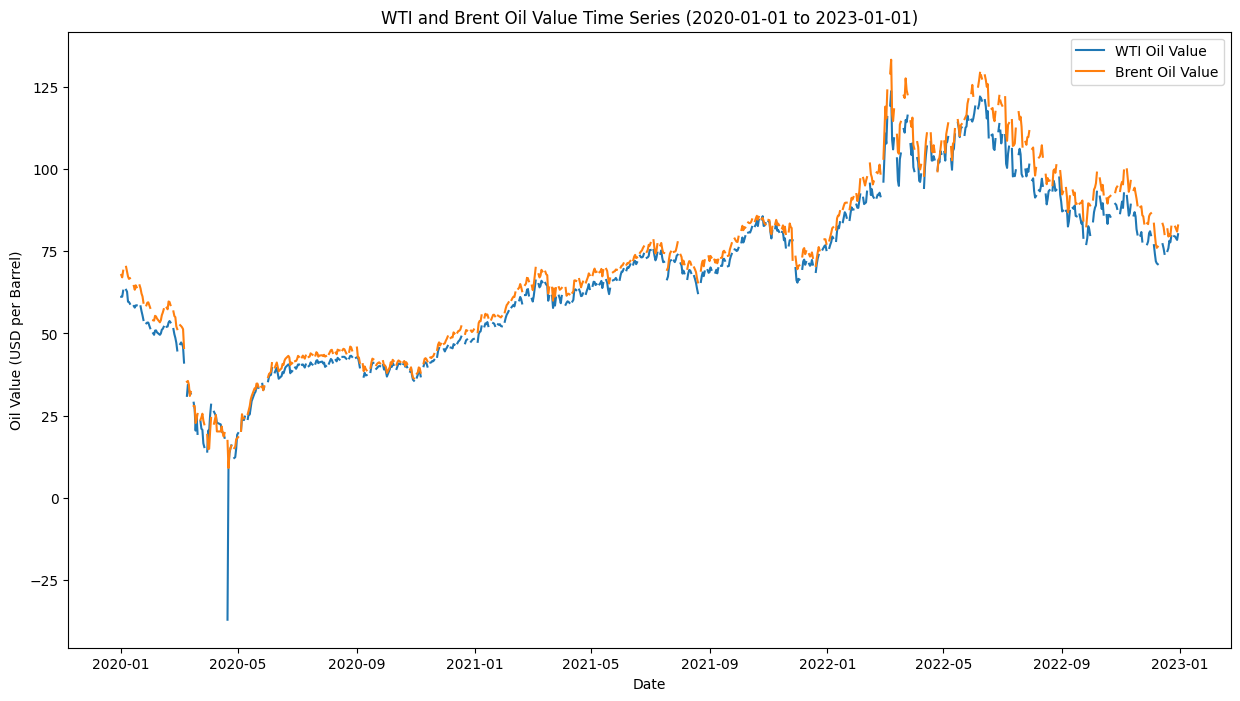

In [80]:
# Setting start & end date to match that of Volza's
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-01-01')

filtered_df = combined_df[(combined_df.index >= start_date) & (combined_df.index <= end_date)]

# Plotting the time series for 'WTI Oil Value' and 'Brent Oil Value'
plt.figure(figsize=(15, 8))
plt.plot(filtered_df.index, filtered_df['WTI Oil Value'], label='WTI Oil Value')
plt.plot(filtered_df.index, filtered_df['Brent Oil Value'], label='Brent Oil Value')
plt.title('WTI and Brent Oil Value Time Series (2020-01-01 to 2023-01-01)')
plt.xlabel('Date')
plt.ylabel('Oil Value (USD per Barrel)')
plt.legend()
plt.show()


##### **1.1 Exporters**

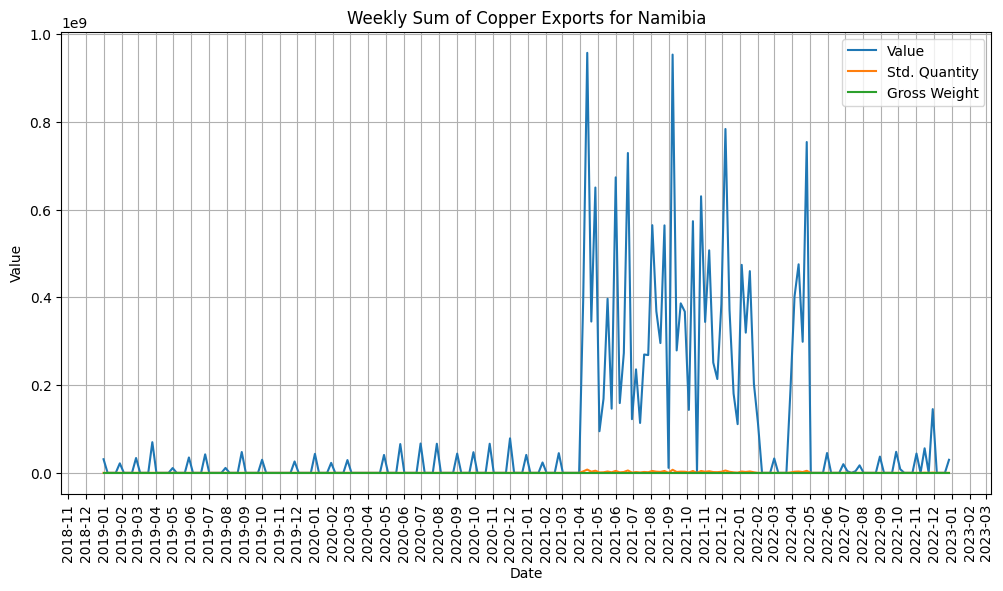

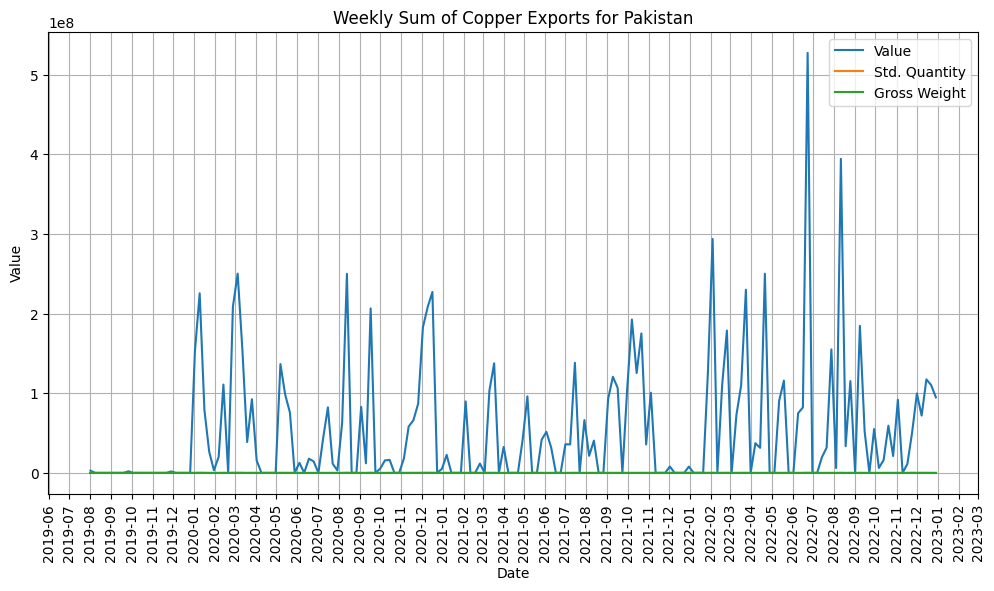

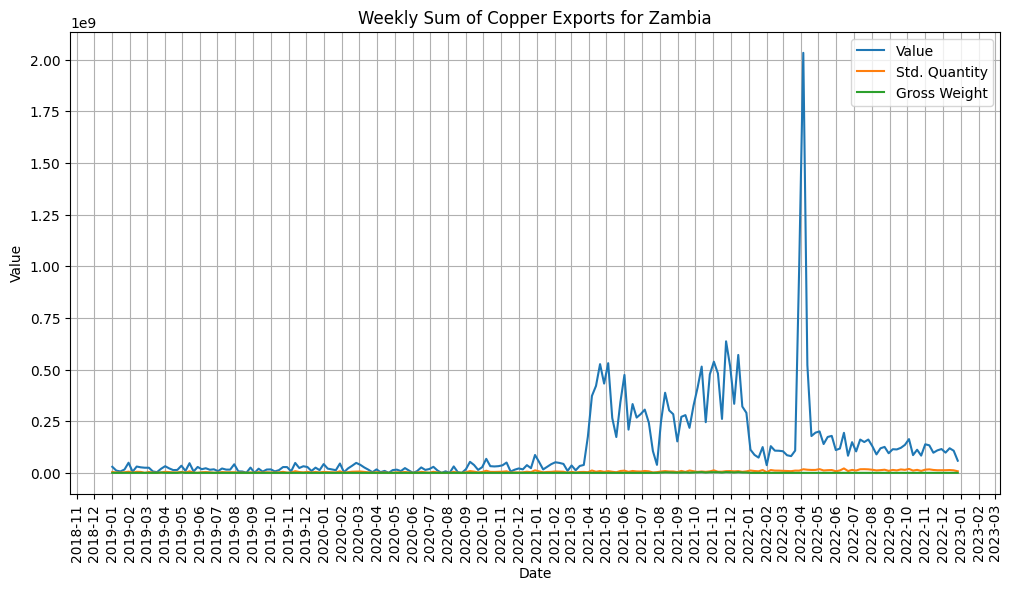

In [81]:
# Graphs in time series
NUMERIC_COLUMN = ['Value', 'Std. Quantity', 'Gross Weight']

# Granularity of time series
TIME_METRIC = '7D'

for country, group in export_group:

    # Resample and sum
    weekly_data = group[NUMERIC_COLUMN].resample(TIME_METRIC).sum()

    # scaling_factor = 1e1
    # weekly_data['Value'] /= scaling_factor

    # Plotting
    plt.figure(figsize=(12, 6))
    for column in NUMERIC_COLUMN:
        plt.plot(weekly_data.index, weekly_data[column], label=column)

    plt.title(f'Weekly Sum of Copper Exports for {country}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

##### **1.2 Importers**

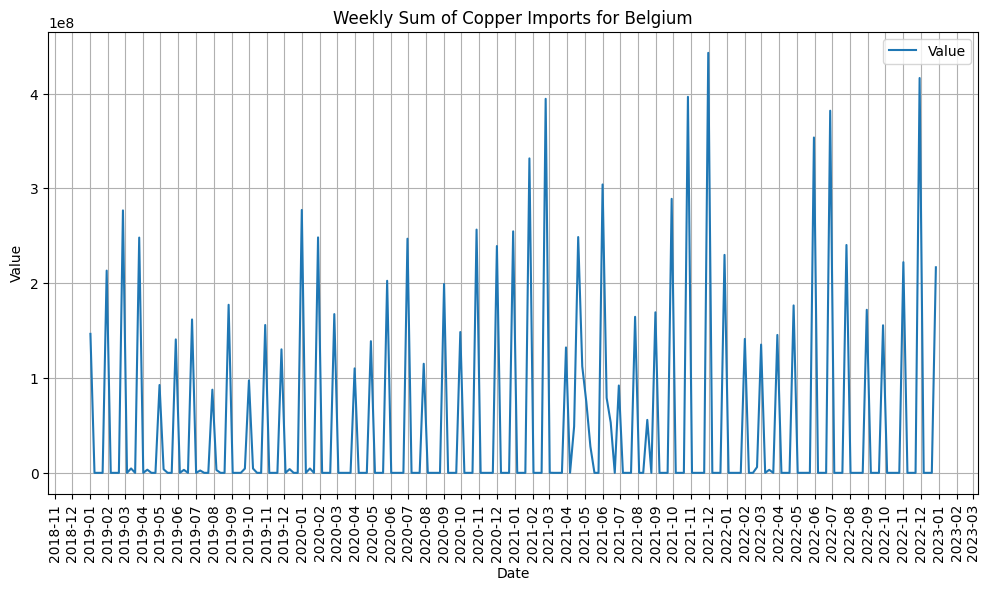

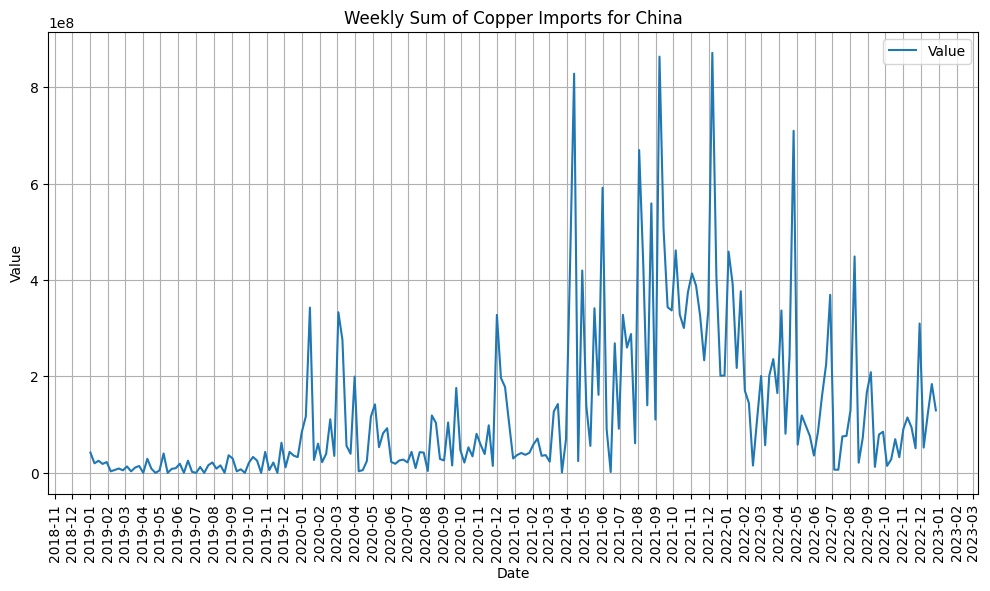

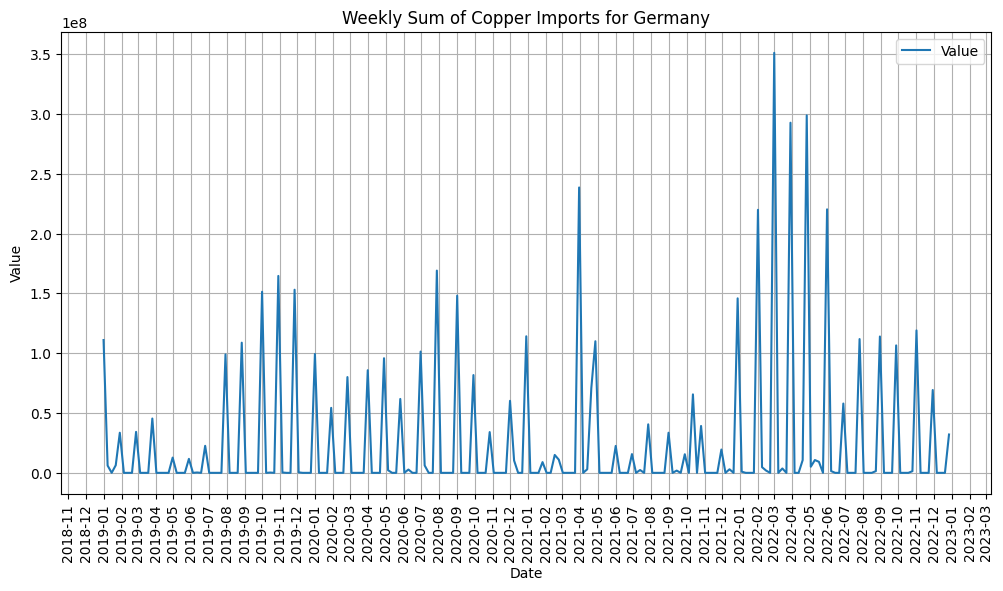

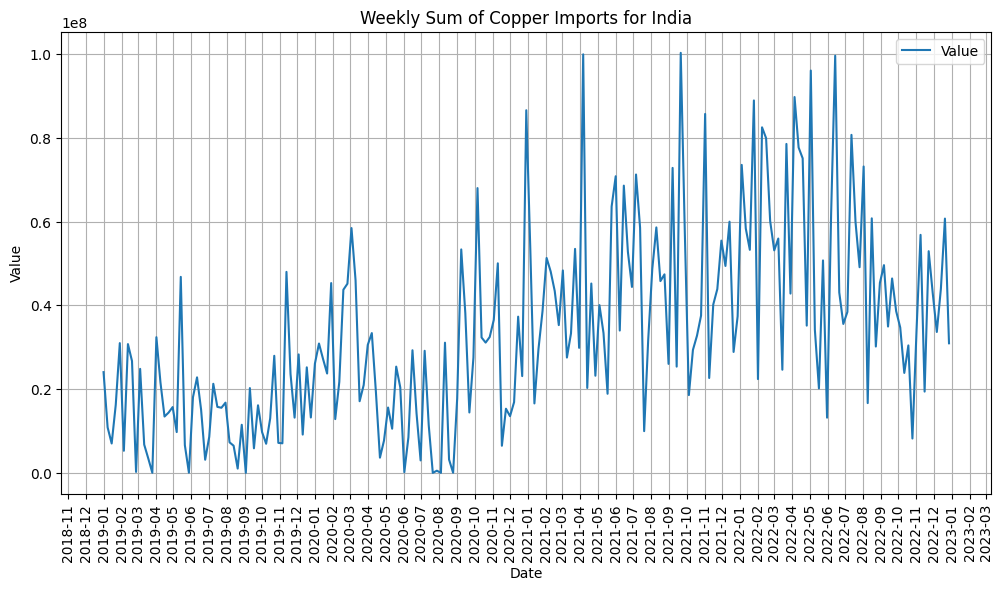

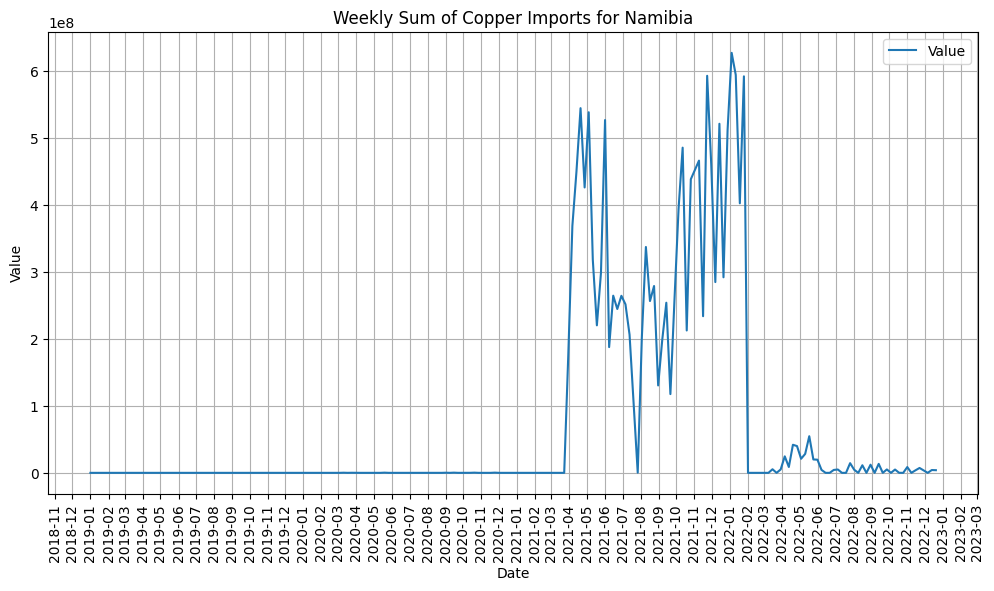

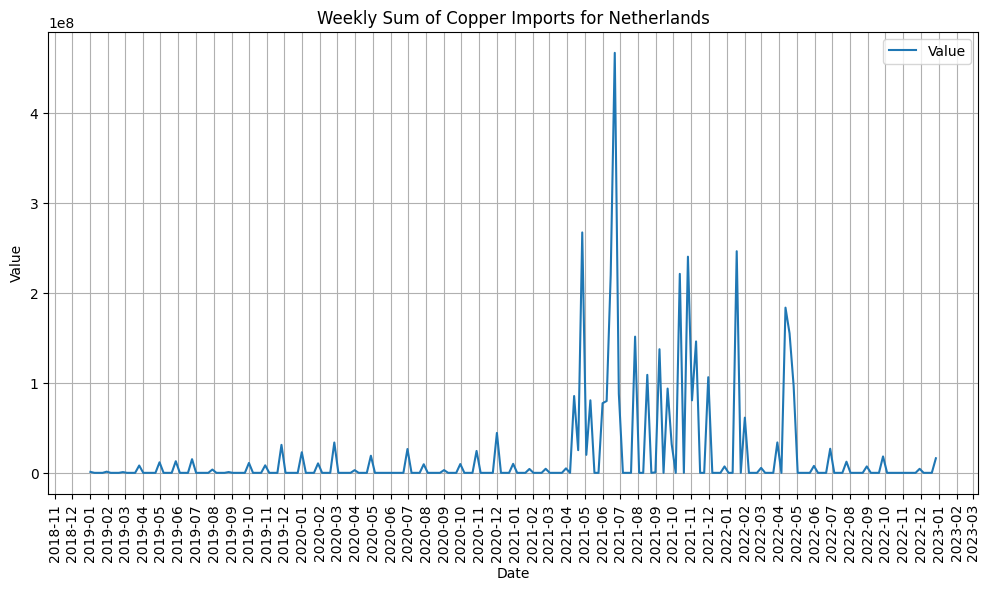

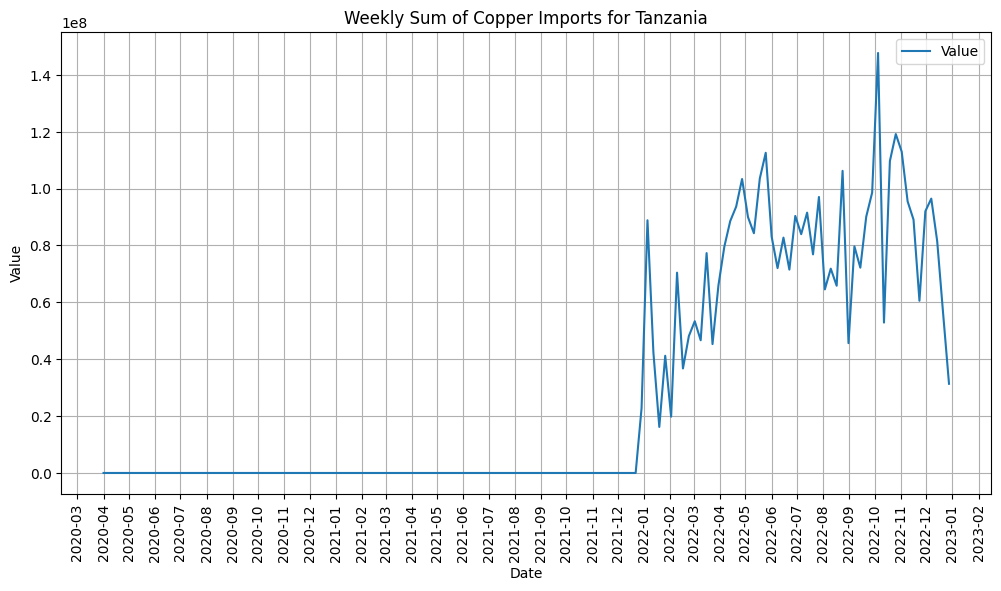

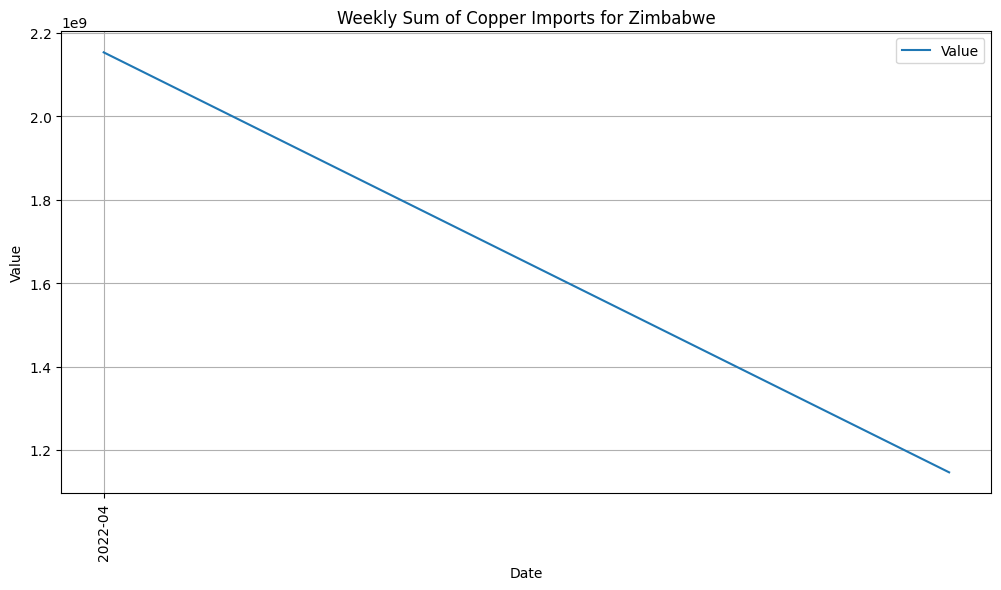

In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# NUMERIC_COLUMN = ['Value', 'Std. Quantity', 'Gross Weight']
NUMERIC_COLUMN = ['Value']


for country, group in import_group:

    # Resample and sum
    weekly_data = group[NUMERIC_COLUMN].resample('7D').sum()

    # scaling_factor = 1e1
    # weekly_data['Value'] /= scaling_factor

    # Plotting
    plt.figure(figsize=(12, 6))
    for column in NUMERIC_COLUMN:
        plt.plot(weekly_data.index, weekly_data[column], label=column)

    plt.title(f'Weekly Sum of Copper Imports for {country}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

#### **2. Correlation**
##### **2.1 Times Series Overlay**

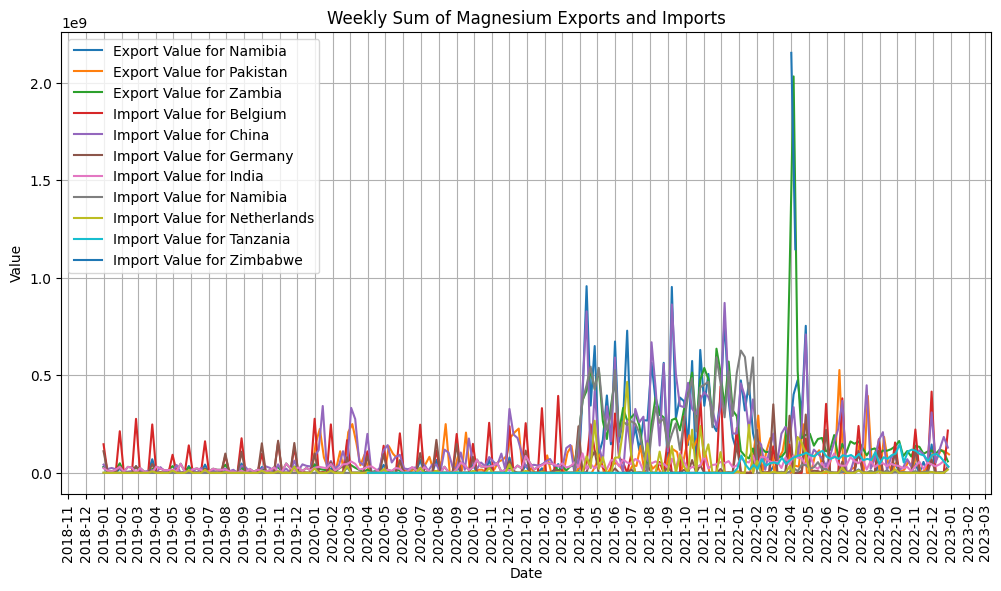

In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Plotting for Exporters
for country, group in export_group:
    weekly_data = group['Value'].resample('7D').sum()
    plt.plot(weekly_data.index, weekly_data, label=f'Export Value for {country}')

# Plotting for Importers
for country, group in import_group:
    weekly_data = group['Value'].resample('7D').sum()
    plt.plot(weekly_data.index, weekly_data, label=f'Import Value for {country}')

plt.title(f'Weekly Sum of Magnesium Exports and Imports')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()


##### **2.2 Spearman & Pearson Correlation**

Pearson Correlation Coefficient: 0.9653945952483236
Spearman Correlation Coefficient: 0.9732653061224488


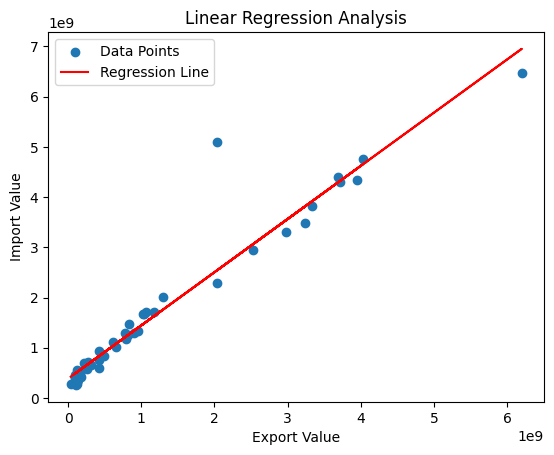

In [84]:
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr\

TIME_METRIC = 'M'

weekly_export = export_combined_df['Value'].resample(TIME_METRIC).sum()
weekly_import = import_combined_df['Value'].resample(TIME_METRIC).sum()

# Merge the two dataframes on the date index
combined_weekly = pd.DataFrame({'Export_Value': weekly_export, 'Import_Value': weekly_import})
combined_weekly.dropna(inplace=True)  

# Correlation Analysis
pearson_corr, _ = pearsonr(combined_weekly['Export_Value'], combined_weekly['Import_Value'])
spearman_corr, _ = spearmanr(combined_weekly['Export_Value'], combined_weekly['Import_Value'])
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")

# Regression Analysis
X = combined_weekly['Export_Value']
y = combined_weekly['Import_Value']
X = sm.add_constant(X)  # Add a constant term to the predictor
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the statistics
# print(model.summary())

# Plotting the linear regression
plt.scatter(combined_weekly['Export_Value'], combined_weekly['Import_Value'], label='Data Points')
plt.plot(combined_weekly['Export_Value'], predictions, color='red', label='Regression Line')
plt.xlabel('Export Value')
plt.ylabel('Import Value')
plt.title('Linear Regression Analysis')
plt.legend()
plt.show()


Country: Belgium
Pearson Correlation Coefficient: 0.1280982691731735
Spearman Correlation Coefficient: 0.16538481888241166


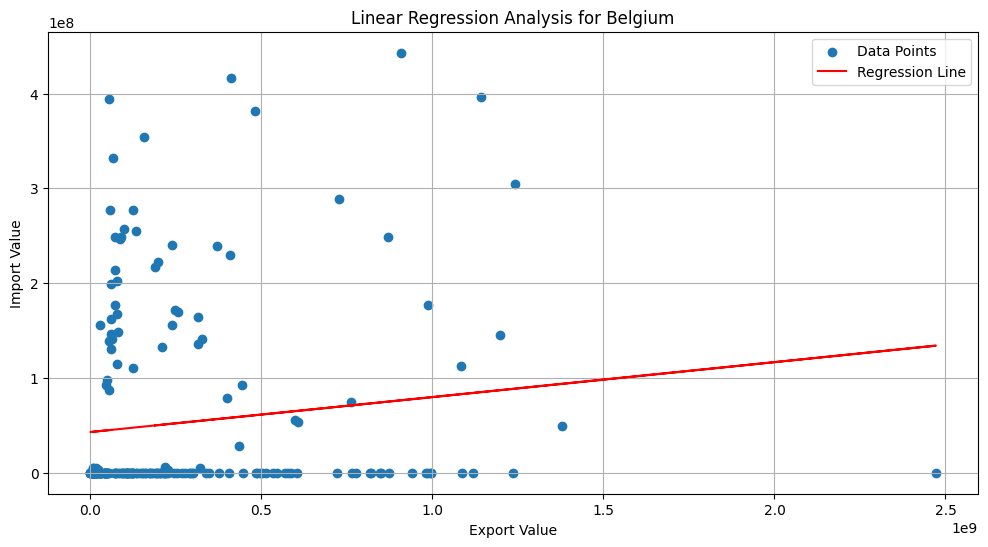

Country: China
Pearson Correlation Coefficient: 0.7880639536343198
Spearman Correlation Coefficient: 0.842921392611125


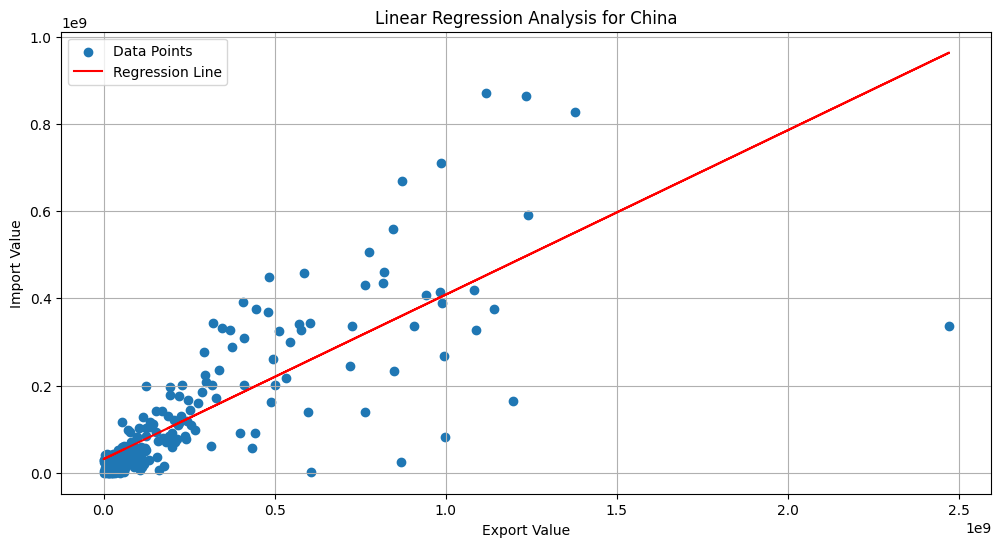

Country: Germany
Pearson Correlation Coefficient: 0.09550763562616468
Spearman Correlation Coefficient: 0.18982026546798778


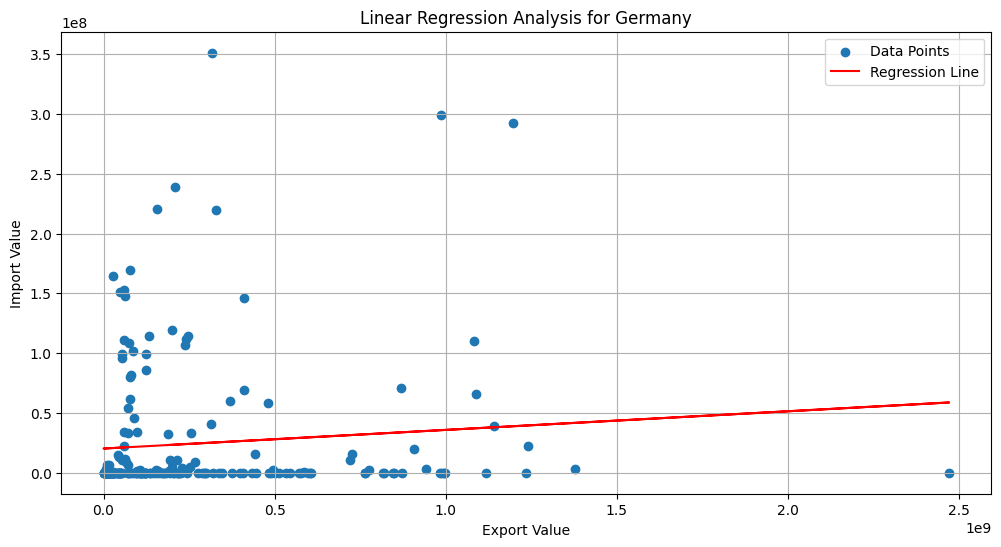

Country: India
Pearson Correlation Coefficient: 0.4700471333127301
Spearman Correlation Coefficient: 0.637108946384829


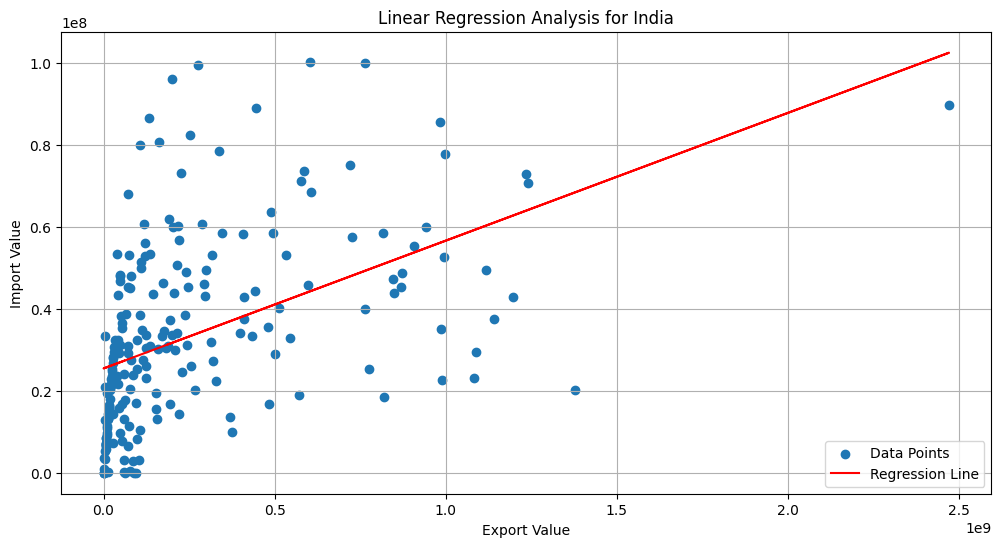

Country: Namibia
Pearson Correlation Coefficient: 0.6779845149665544
Spearman Correlation Coefficient: 0.7430843154982815


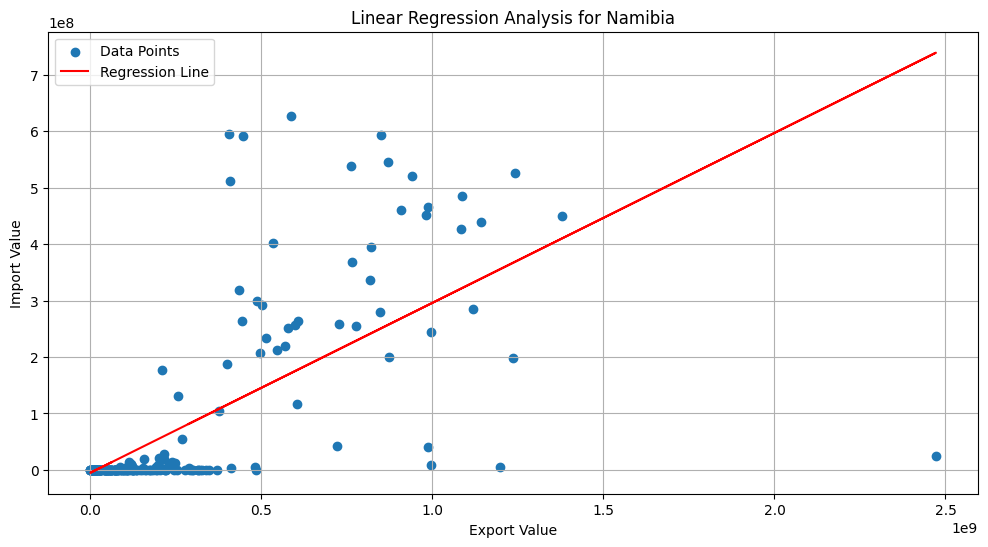

Country: Netherlands
Pearson Correlation Coefficient: 0.5078114328233939
Spearman Correlation Coefficient: 0.39369368391776316


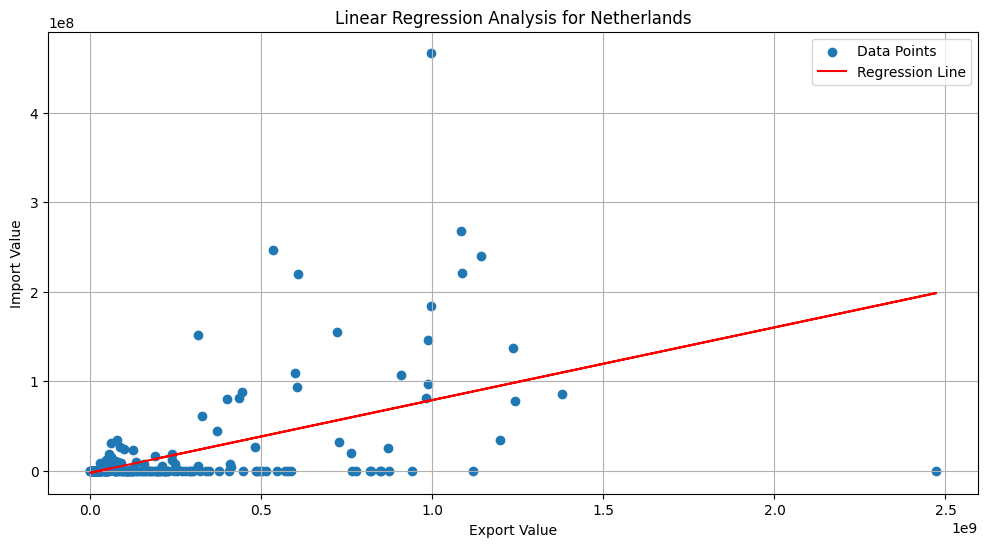

Not enough data for correlation and regression analysis for Tanzania
Not enough data for correlation and regression analysis for Zimbabwe


In [85]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Change to 'D' / '7D' / 'M' to affect granularity
TIME_METRIC = '7D'

weekly_export = export_combined_df['Value'].resample(TIME_METRIC).sum()

for country, import_data in import_group:
    weekly_import = import_data['Value'].resample(TIME_METRIC).sum()

    # Merge the export and import data for the specific country
    combined_weekly = pd.DataFrame({'Export_Value': weekly_export, 'Import_Value': weekly_import})
    combined_weekly.dropna(inplace=True)  # Dropping NaN values

    # Ensure there are enough data points
    if combined_weekly.shape[0] > 1:
        # Correlation Analysis
        pearson_corr, _ = pearsonr(combined_weekly['Export_Value'], combined_weekly['Import_Value'])
        spearman_corr, _ = spearmanr(combined_weekly['Export_Value'], combined_weekly['Import_Value'])
        print(f"Country: {country}")
        print(f"Pearson Correlation Coefficient: {pearson_corr}")
        print(f"Spearman Correlation Coefficient: {spearman_corr}")

        # Regression Analysis
        X = combined_weekly['Export_Value']
        y = combined_weekly['Import_Value']
        X = sm.add_constant(X)  # Add a constant term to the predictor
        model = sm.OLS(y, X).fit()
        predictions = model.predict(X)

        # Print out the statistics for each country
        # print(f"Linear Regression Model Summary for {country}:")
        # print(model.summary())

        # Plotting the linear regression
        plt.figure(figsize=(12, 6))
        plt.scatter(combined_weekly['Export_Value'], combined_weekly['Import_Value'], label='Data Points')
        plt.plot(combined_weekly['Export_Value'], predictions, color='red', label='Regression Line')
        plt.xlabel('Export Value')
        plt.ylabel('Import Value')
        plt.title(f'Linear Regression Analysis for {country}')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Not enough data for correlation and regression analysis for {country}")


In [86]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming weekly_export and weekly_import are already calculated as before

# Granger Causality Test
max_lag = 2  # Maximum number of lags to test for - can be adjusted
print("Granger Causality Test Results:")
granger_test_result = grangercausalitytests(combined_weekly, max_lag, verbose=True)

# Cross-Correlation Analysis
max_lags = 15  # Maximum lags in each direction
ccf = pd.Series(sm.tsa.stattools.ccf(combined_weekly['Export_Value'], combined_weekly['Import_Value'], unbiased=True))
ccf = ccf[:max_lags * 2 + 1]  # Keep only the first 2*max_lags+1 lags

# Plotting the Cross-Correlation Function
plt.figure(figsize=(10, 6))
ccf.plot(kind='bar')
plt.title('Cross-Correlation Function (Limited Lags)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.xticks(ticks=range(2 * max_lags + 1), labels=[f"{i-max_lags}" for i in range(2 * max_lags + 1)])
plt.show()


Granger Causality Test Results:


c:\Users\manim\ONR\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ValueError: Insufficient observations. Maximum allowable lag is -1